In [2]:
import cPickle as pickle
import itertools
import numpy as np
from scipy.spatial.distance import cdist
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,Conv1D,GlobalMaxPool1D,Dropout
from keras.layers.embeddings import Embedding
from keras import optimizers

Using TensorFlow backend.


In [4]:
word_vocab = pickle.load(open("train_data_filtered_vocab.pkl", "rb" ))
words,defs = pickle.load(open("train_data_filtered.pkl", "rb" ))

In [5]:
word_embs = pickle.load(open("../embeddings/D_cbow_pdw_8B.pkl", "rb" ))

In [7]:
training_words = words[0:1000]
training_defs = defs[0:1000]

In [8]:
target_embs = []
for word in training_X:
    target_embs.append(word_embs[word])

In [11]:
len(target_embs[0])

500

## Some research today
We can use embedding layer directly to generate uniform embeddings for training.
For feeding pre-trained word embeddings, we can use an embedding matrix defined in Fake news ipython nb

Things to take care while inputting data:
* Pad sequences to max length (https://keras.io/preprocessing/sequence/)
* Use masking so that index 0 i.e. padded 0 is masked out. Good explanation on embedding layer and masking is given here (https://keras.io/layers/embeddings/). Only caveat is that we need to use vocab indices starting from 1. Should not be a problem I suppose?

Second last comment on this thread gives clear examples of masking with padding for LSTM in keras (https://github.com/keras-team/keras/issues/2375)

Seems like `cosine proximity` is a standard loss in Keras.
Related links https://github.com/keras-team/keras/issues/3031, https://github.com/keras-team/keras/issues/5046

Hyper params defined in the code. Cross-reference with paper


`
options = {
        'dim_word': [256],
        'dim': [512],
        'n_layers': [1],
        'n-words': [30000], 
        'optimizer': ['adadelta'],
        'decay-c': [0.], 
        'use-dropout': [0],
        'learning-rate': [0.0001],
        'use_target_as_input': [True],
        'reload': [False]}
`

In [2]:
#Create vocab
def create_vocab(words,defs):
    word_vocab = {}
    #Make sure index starts with 1, since 0 is mask on
    idx = 1
    for word in words:
        if word not in word_vocab:
            word_vocab[word] = idx
            idx += 1

    for word_def in defs:
        for word in word_def:
            if word not in word_vocab:
                word_vocab[word] = idx
                idx += 1
    print('Unique words found in vocab ',idx)
    return word_vocab

In [8]:
training_vocab = create_vocab(training_words,training_defs)

('Unique words found in vocab ', 2776)


In [9]:
len(training_vocab)

2775

In [27]:
#Create training instances
training_x = []
training_y = []
for w,d in itertools.izip(training_words,training_defs):
    word_seq = [training_vocab[t] for t in d if t in training_vocab]
    training_x.append(word_seq)
    training_y.append(word_embs[w])

In [34]:
X_train = pad_sequences(training_x, maxlen=100, dtype='int32', padding='post', truncating='post')
Y_train = np.array(training_y)

In [35]:
X_train.shape, Y_train.shape

((1000, 100), (1000, 500))

In [42]:
#Hyper params definition (from paper)
vocab_len = len(training_vocab) + 1 #To take care of masking
max_len = 100 #Number of timesteps
input_emb_dim = 256 #Dimension of learned input embeddings
output_emb_dim = 500 #Standard dim of output provided
lstm_units = 512
batch_size = 16
epochs = 2

In [39]:
#Define simple LSTM sequential model
model = Sequential()
model.add(Embedding(vocab_len, input_emb_dim, mask_zero=True, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(output_emb_dim, activation='relu'))

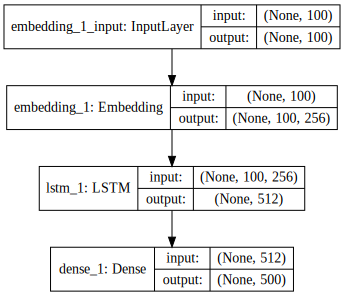

In [40]:
#Visualize model
from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [45]:
#Compile model
model.compile('adadelta',loss='cosine_proximity',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 256)          710656    
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               256500    
Total params: 2,542,068
Trainable params: 2,542,068
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
#Start training the sequential model here
model.fit(X_train,Y_train,batch_size=16,epochs=5,verbose=1,validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 55s 61ms/step - loss: -0.5065 - acc: 0.5078 - val_loss: -0.2889 - val_acc: 0.3300
Epoch 2/5
900/900 [==============================] - 55s 61ms/step - loss: -0.5401 - acc: 0.6111 - val_loss: -0.2941 - val_acc: 0.3300
Epoch 3/5
900/900 [==============================] - 55s 62ms/step - loss: -0.5626 - acc: 0.6533 - val_loss: -0.2913 - val_acc: 0.3400
Epoch 4/5
900/900 [==============================] - 55s 61ms/step - loss: -0.5798 - acc: 0.7011 - val_loss: -0.2941 - val_acc: 0.3200
Epoch 5/5
900/900 [==============================] - 55s 62ms/step - loss: -0.5920 - acc: 0.7411 - val_loss: -0.2866 - val_acc: 0.3400


## Some utilities to compute resulting metrics as described in the paper
To quantify the quality of a given ranking, we report
three statistics: 
* the median rank of the correct answer (over the whole test set, lower better)
* the proportion of training cases in which the correct answer appears in the top 10/100 in this ranking (accuracy@10/100 - higher better)
* the variance of the rank of the correct answer across the test set (rank variance - lower better).

In [24]:
#Calculate euclidean distance
A = np.array([[1,1], [3,4]])
B = np.array([[1,2]])
a = cdist(A,B,'euclidean').flatten()

#Finding top k closest points
A = np.array([11, 7, 9, 2, 0.1, 17, 17, 1.5])
k = 3
idx = np.argpartition(A, 3)[:3]
print(idx)

[4 7 3]


In [34]:
# Read output words and create output vocab
output_words = [line.strip() for line in open('../Defgen_evals/output_shortlist.txt')]
output_vocab = {k: v for v, k in enumerate(output_words)}

In [43]:
'''
Prepare test data from files
Only include words present in the output_vocab
'''
def create_test_data(file_name, vocab_obj):
    X_test = []
    Y_test = []
    with open(file_name) as f:
        for line in f:
            test_wd = line.strip().split('\t')
            if test_wd[0] in vocab_obj:
                Y_test.append(test_wd[1])
                X_test.append(test_wd[0])
    return X_test,Y_test

In [44]:
#Example usage to create test output. x and y are strings
x,y = create_test_data('../Defgen_evals/Reverse_Dictionary/WN_seen_correct.txt',output_vocab)

In [25]:
'''
Returns true if label in top k closest for pred in labels
pred - 500d emb
label - 500d emb
points - list of word emb of all possible output words
k - integer (10/100)
'''
def find_top_k_dist (points, pred, label, k):
    label_idx = output_vocab[labael]
    dist_list = cdist(points, np.array([pred]), 'euclidean').flatten() #Convert 2d into 1d array
    result_indices = np.argpartition(dist_list, k)[:k]
    if label_idx in result_indices:
        return True
    return False

## To do

* Run function for some test data to confirm correctness
* Train on entire data set and report results